In [7]:
#loading the data 
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

DIR='C://Users//imdin//OneDrive//Documents//GAMS//Kidney_stone_detection-main//CT_Scan'
CATEGORIES=["Normal","Kidney_stone"]
training_data=[]

def train_data():
    for categories in CATEGORIES:
        path=os.path.join(DIR,categories)
        class_num=CATEGORIES.index(categories)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(128,128))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
train_data()
random.shuffle(training_data)
#im using random shuffle just to prevent overfitting isssues

0


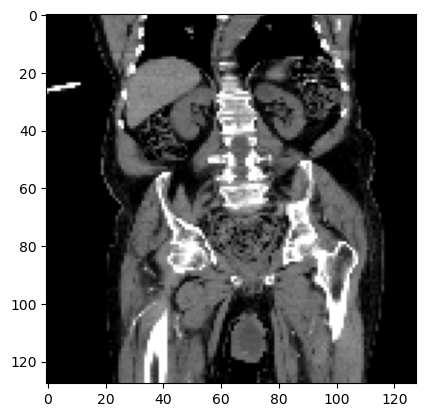

In [8]:
#image bedfore Preprocessing
plt.imshow(training_data[3][0],cmap='gray')
print(training_data[3][1])

In [9]:
X=[]
y=[]
for features,labels in training_data:
    X.append(features)
    y.append(labels)
X=np.array(X)
y=np.array(y)

In [10]:
X.shape

(1790, 128, 128, 3)

In [11]:
#checking the dimesnsions of Train and Test sets
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.1,random_state=1)
print(len(Xtrain),len(Xtest),len(ytrain),len(ytest))
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)


1611 179 1611 179


In [12]:
#required Libraries
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Conv2D, Flatten, Convolution2D, Activation
from keras.layers import Dropout, MaxPooling2D
from tensorflow.keras.applications import ResNet50,Xception
import pickle

In [13]:
#Data preprocessing
def median_blur(img):
    mb = cv2.medianBlur(img, 1)
    res=hist(mb)
    return res
    
def hist(img):
    res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gamma_corrected = np.array(255*(res / 255) ** 2.5, dtype = 'uint8')
    thres=thresholding_img(gamma_corrected)
    return thres

def thresholding_img(img):
    ret, thresh1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    return thresh1

processed_img=[]
for img in Xtrain:
    res=median_blur(img)
    processed_img.append(res)
    
processed_img=np.array(processed_img)

In [14]:
#Model Function
def build_model():
    model = keras.Sequential([
        keras.layers.Convolution2D(
            filters=64,
            kernel_size=3,
            activation='relu',
            input_shape=(128, 128, 1)
        ),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        
        keras.layers.Conv2D(
            filters=112,
            kernel_size=3,
            activation='relu'
        ),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=80,
            activation='relu'
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

model = build_model()


C:\Users\imdin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
#model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 112)    │        64,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │     1,514,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,579,665 (6.03 MB)

 Trainable params: 1,579,665 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#fitting the model
model.fit(processed_img,ytrain,epochs=15,batch_size=35,verbose=1,validation_split=0.1)

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.5963 - loss: 39.2100 - val_accuracy: 0.7901 - val_loss: 0.4735
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - accuracy: 0.7897 - loss: 0.4759 - val_accuracy: 0.8148 - val_loss: 0.4047
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - accuracy: 0.8296 - loss: 0.3993 - val_accuracy: 0.8272 - val_loss: 0.5092
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 447ms/step - accuracy: 0.9154 - loss: 0.2362 - val_accuracy: 0.8765 - val_loss: 0.4177
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - accuracy: 0.9282 - loss: 0.2221 - val_accuracy: 0.8457 - val_loss: 0.5877
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.9533 - loss: 0.1458 - val_accuracy: 0.8704 - val_loss: 0.5318
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.9639 - loss: 0.1078 - val_accuracy: 0.9012 - val_loss: 0.5034
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.9614 - loss: 0.0927 - val_acc

In [17]:
Xtest_processed_img=[]
for img in Xtest:
    res=median_blur(img)
    Xtest_processed_img.append(res)
    
Xtest_processed_img=np.array(Xtest_processed_img)

In [18]:
ypred=model.predict(Xtest_processed_img)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


In [27]:
from sklearn.metrics import confusion_matrix
cc=confusion_matrix(ytest,(ypred>0.5)*1)
cc
from sklearn.metrics import classification_report


# The model's predict function gives you probabilities, and you're thresholding them to get binary predictions
y_pred = (model.predict(Xtest_processed_img) > 0.5) * 1

# Now, generate the classification report
report = classification_report(ytest, y_pred)
print(report)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

           0       0.84      0.96      0.89        93
           1       0.95      0.80      0.87        86

    accuracy                           0.88       179
   macro avg       0.89      0.88      0.88       179
weighted avg       0.89      0.88      0.88       179



In [26]:
#Test Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(ytest,(ypred>0.5)*1)*100


91.62011173184358

In [21]:
import numpy as np
print("Dimensions of y_test:", ytest.shape)


Dimensions of y_test: (179,)


Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9977 - loss: 0.0047 - val_accuracy: 0.8827 - val_loss: 1.3196
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9952 - loss: 0.0164 - val_accuracy: 0.8704 - val_loss: 1.8275
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9932 - loss: 0.0169 - val_accuracy: 0.8519 - val_loss: 1.5051
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9931 - loss: 0.0129 - val_accuracy: 0.9136 - val_loss: 1.6638
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9951 - loss: 0.0079 - val_accuracy: 0.9012 - val_loss: 1.9434
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9981 - loss: 0.0062 - val_accuracy: 0.9074 - val_loss: 1.7274
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9940 - loss: 0.0125 - val_accuracy: 0.8951 - val_loss: 1.4479
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.8889 - v

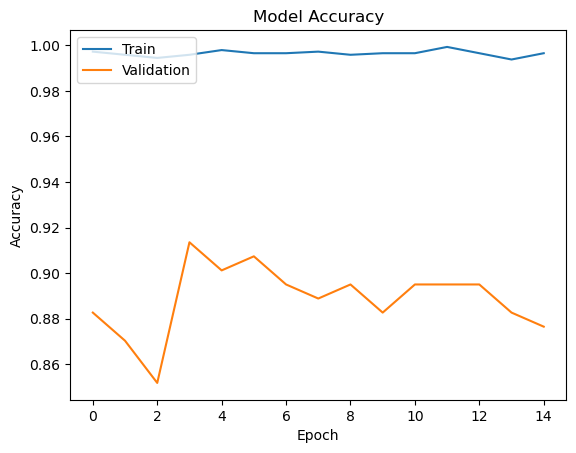

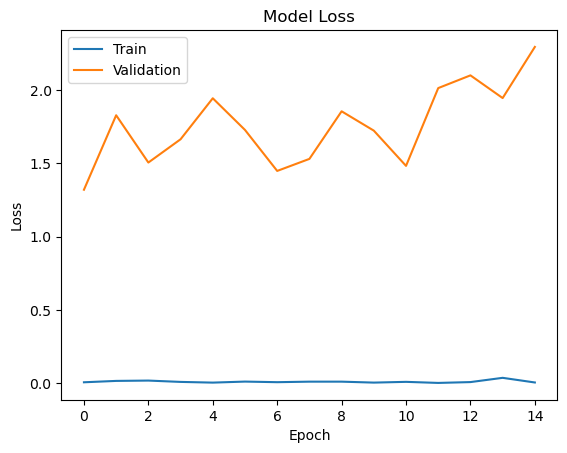

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        93
           1       0.90      0.87      0.89        86

    accuracy                           0.89       179
   macro avg       0.89      0.89      0.89       179
weighted avg       0.89      0.89      0.89       179



In [29]:
#Model Metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Train the model with the updated parameters
history = model.fit(processed_img, ytrain, epochs=15, batch_size=35, verbose=1, validation_split=0.1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

import numpy as np
from sklearn.metrics import classification_report



# The model's predict function gives you probabilities, and you're thresholding them to get binary predictions
y_pred = (model.predict(Xtest_processed_img) > 0.5) * 1

#classification report
report = classification_report(ytest, y_pred)
print(report)



In [89]:
!pip install h5py

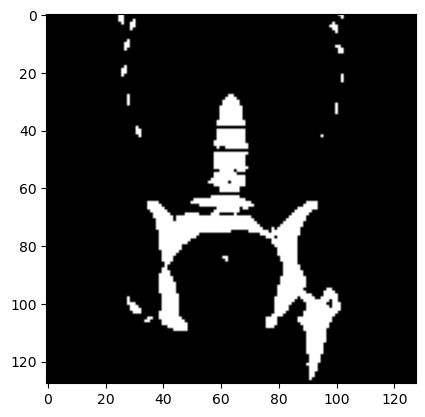

In [38]:
#code for Preprocessed images
plt.imshow(res,cmap='gray')
plt.show()